In [1]:
# initalize 
import torch
import os
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
print("Initialized successfully") 


Initialized successfully


In [2]:
# get device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [22]:
# design model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            # nn.ReLU(),
            # nn.Linear(128, 10)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        return logits
        

In [23]:
# set up a model
model = NeuralNetwork().to(device)
print(model)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0147, -0.0127, -0.0038,  ...,  0.0097, -0.0261, -0.0073],
        [-0.0028, -0.0169, -0.0171,  ...,  0.0041, -0.0252, -0.0106]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([ 0.0322, -0.0312], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([10, 512]) | Values: tensor([[-0.0022, -0.0194, -0.0397,  ..., -0.0313, -0.0097, -0.0394],
        [ 0.0300,  0.0164, -0.0093,  ...,  0.0364,  0.0101, -0.0387]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([10]) | Values: tensor([0.0269, 0

In [6]:
# Load data
train_data = datasets.FashionMNIST(
    root = "data", 
    train = True,
    download = True, 
    transform = ToTensor(),
    # target_transform = Lambda(lambda y:torch.zeros(10,dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)
test_data = datasets.FashionMNIST(
    root = "data", 
    train = False,
    download = True,
    transform = ToTensor()
    # target_transform = Lambda(lambda y:torch.zeros(10,dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(train_data[5][0].device)
print("Done!")

cpu
Done!


- function of train_loop does 4 things in each batch:
    1. send tensor to cuda, initialize model
    2. front propagation
    3. back propagation
    4. use optimizer adjust learning_rate & empty gradient
- function of test_loop does 3 things in each batch:
    1. send tensor to cuda, initialize model
    2. front propagation
    3. accumulate accuracy and loss
it is obvious that in test data, back propagation is not required.


In [ ]:


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward propagation
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.item()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(dtype=torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train, model, loss_fn, optimizer))
    test_loss.append(test_loop(test, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 2.333817  [   64/60000]
loss: 2.290663  [   64/60000]
loss: 2.286063  [   64/60000]
loss: 2.270595  [   64/60000]
loss: 2.293652  [   64/60000]
loss: 2.325593  [   64/60000]
loss: 2.312386  [   64/60000]
loss: 2.295892  [   64/60000]
loss: 2.299388  [   64/60000]
loss: 2.292578  [   64/60000]
loss: 2.303730  [   64/60000]
loss: 2.279035  [   64/60000]
loss: 2.275288  [   64/60000]
loss: 2.289971  [   64/60000]
loss: 2.288756  [   64/60000]
loss: 2.302202  [   64/60000]
loss: 2.288798  [   64/60000]
loss: 2.287708  [   64/60000]
loss: 2.264186  [   64/60000]
loss: 2.302464  [   64/60000]
loss: 2.307961  [   64/60000]
loss: 2.298779  [   64/60000]
loss: 2.281107  [   64/60000]
loss: 2.290153  [   64/60000]
loss: 2.285956  [   64/60000]
loss: 2.310469  [   64/60000]
loss: 2.294561  [   64/60000]
loss: 2.294259  [   64/60000]
loss: 2.278278  [   64/60000]
loss: 2.280293  [   64/60000]
loss: 2.288620  [   64/60000]
loss: 2.280567  [   64/60000]


In [ ]:
# TODO: how to directly switch tensor into numerical float? perhaps tensor.item()?
train_loss = [i for i in train_loss]
test_loss = [i for i in test_loss]
print(train_loss, test_loss)

[1.8997015953063965, 1.3892912864685059, 0.9437657594680786, 0.9074153900146484, 0.995407223701477, 0.7388341426849365, 0.6282996535301208, 0.7694500684738159, 0.7118653059005737, 0.8590540885925293] [1.78630132659985, 1.3723316222998747, 1.133491156207528, 1.000603274175316, 0.9168760005835515, 0.8594796000772221, 0.8171912720248957, 0.7842940448955366, 0.7583797315883029, 0.7355273700064155]


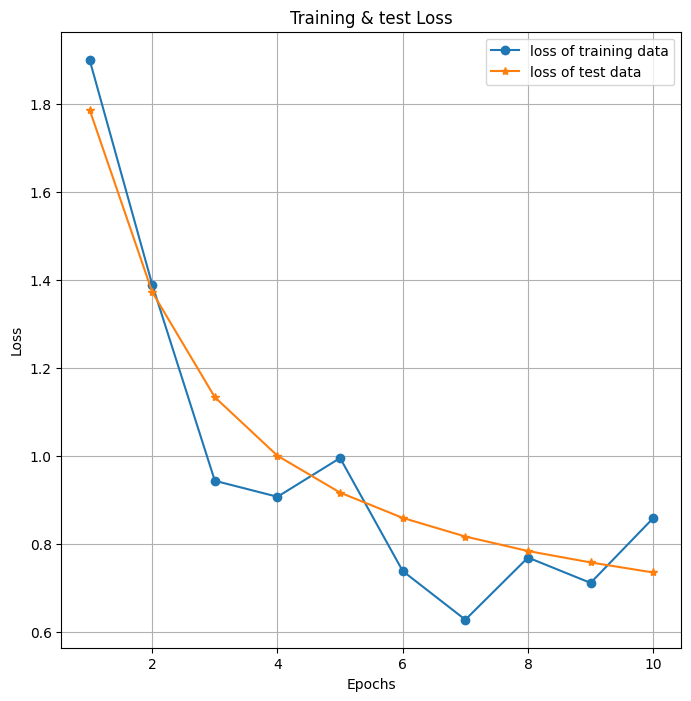

In [33]:


figure = plt.figure(figsize=(8, 8))
plt.plot(list(range(1, epochs+1)), train_loss, label="loss of training data",marker='o')
plt.plot(list(range(1, epochs+1)), test_loss, label="loss of test data",marker='*')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & test Loss")
plt.legend()
plt.grid(True)
plt.show()

### In conclusion, to create a Neural network, steps as followings are needed:
- import relevant libraries
    - e.g. torch is the basis, torch.utils.data for dataset in torch, and matplotlib for graphing 
- design your model
    - remember to inherite from father class nn.Module
    - two parts are required；
        1. __init__ method. Here you design all the process that are needed before calculating the loss funcion
            - e.g. flatten input image, and also your front_propagation steps
        2. forward method. Here you use the properties defined in __init__, start with image process, end with the output of logits  
- select accelerator
    - training a model on a cpu is slow, so when define a model, use .to(torch.accelerator.current_accelerator().type) to switch to cuda
- load data
    - remember to transform them into DataLoader
- design process of training & test
    - for training data:
        - set model to mode of .train()
        - calculate loss from batch to batch
        - backprop and optimize
    - for test data:
        - set model to mode of .eval()
        - accumulate loss and accuracy in each batch
- choose hyperparameters, loss function, optimizer
- train you model
- graph the result